# Data Scientist Challenge

#### This project is dedicated to analyzing students' behavior and workflow with specific objectives in mind. The primary goals include examining the demographic details of individuals who are more likely to succeed in the test, elucidating the effectiveness of their study skills, identifying noteworthy trends within the dataset, and providing insightful analyses regarding their significance or underlying causes.  

#### Furthermore, the project aims to develop a predictive model capable of determining whether a student is likely to pass the test. The findings of this analysis will be shared, and recommendations will be offered to enhance strategies for supporting more individuals in successfully passing the test. The ultimate objective is to contribute to the creation of more accurate predictive models based on the valuable insights derived from this research.

## About this dataset
The data set includes information about the students’ age, nationality, gender, as well as information about their studying habits. There is also a binary column expressing whether or not the students passed an important test.

|Column Name| Description|
|:------------|:------------|
|sex| Gender of the student|
|lang| Language of the student|
|country| Country of residence of the student|
|age| Age of the student|
|hours_studied| Hours invested in studies|
|dojo_class| If the student is enroled in this class (Binary)|
|test_prep| If the student is enroled in this class (Binary)|
|pass| If the student has passed the test (Binary)|
|notes| Additional notes or comments related to the students |

In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Setting random seed 
RSEED = 42
warnings.filterwarnings("ignore")

### Fetching the data from the database

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from sqlalchemy import create_engine

#read the database string from the .env
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [4]:
query_string = "SELECT * FROM takemehome.triad "
df_sqlalchemy = pd.read_sql(query_string, db)

In [5]:
df_sqlalchemy.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,None
1,Male,Japanese,Japan,22,7.814520,False,False,True,None
2,Male,Japanese,Japan,27,4.213682,False,False,True,None
3,Male,Japanese,Japan,24,NaN,False,False,True,None
4,Female,Japanese,Japan,21,3.248907,False,False,False,None


In [6]:
df_sqlalchemy.to_csv('data/students.csv',index=False) #saving the data into a .csv file

In [7]:
df = pd.read_csv('data/students.csv').rename(columns={'lang': 'language'})
df.head()

,sex,language,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,NaN
1,Male,Japanese,Japan,22,7.814520,False,False,True,NaN
2,Male,Japanese,Japan,27,4.213682,False,False,True,NaN
3,Male,Japanese,Japan,24,NaN,False,False,True,NaN
4,Female,Japanese,Japan,21,3.248907,False,False,False,NaN


#### First inspection of the data / EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   language       5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass           5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.2+ KB


In [9]:
df.columns

Index(['sex', 'language', 'country', 'age', 'hours_studied', 'dojo_class',
       'test_prep', 'pass', 'notes'],
      dtype='object')

Checking unique values

In [10]:
print(f'Unique language: {df["language"].unique()}')
print('-'*20)
print(f'Unique countries: {df["country"].unique()}')
print('-'*20)
print(f'Unique ages: {df["age"].unique()}')
print('-'*20)
print(f'Unique notes: {df["notes"].unique()}')

Unique language: ['Japanese' 'Finnish' 'English' 'Spanish' 'French' 'Italian']
--------------------
Unique countries: ['Japan' 'Finland' 'Australia' 'Mexico' 'New Zealand' 'USA' 'UK' 'Spain'
 'France' 'Italy']
--------------------
Unique ages: [20 22 27 24 21 18 23 19 29 25 32 34 26 42 40 31 28 35 48 36 37 30 47 38
 44 43 33 39 49 41 46 45 50]
--------------------
Unique notes: [nan 'CON' '@{[system "touch /tmp/blns.fail"]}' '`⁄€‹›ﬁﬂ‡°·‚—±'
 '᚛ᚄᚓᚐᚋᚒᚄ\u1680ᚑᚄᚂᚑᚏᚅ᚜' 'Œ„´‰ˇÁ¨ˆØ∏”’' '😍'
 'ABC<div style="x:exp\\x00ression(javascript:alert(1)">DEF'
 '\xad\u0600\u0601\u0602\u0603\u0604\u0605\u061c\u06dd\u070f\u180e\u200b\u200c\u200d\u200e\u200f\u202a\u202b\u202c\u202d\u202e\u2060\u2061\u2062\u2063\u2064\u2066\u2067\u2068\u2069\u206a\u206b\u206c\u206d\u206e\u206f\ufeff\ufff9\ufffa\ufffb\U000110bd\U0001bca0\U0001bca1\U0001bca2\U0001bca3\U0001d173\U0001d174\U0001d175\U0001d176\U0001d177\U0001d178\U0001d179\U0001d17a\U000e0001\U000e0020\U000e0021\U000e0022\U000e0023\U000e0024\U000e0025\U000e0026\

Since the 'notes' column contains a variety of values like HTML, JavaScript, Symbols etc, I will drop this column in order to not invest too much time trying to understand the correlation if any. Besides that, it has more than 4000 NAN

In [11]:
df = df.drop('notes', axis=1)

In [12]:
df.describe()

,age,hours_studied
count,5000.000000,3018.000000
mean,25.873400,4.964076
std,7.349978,3.203037
min,18.000000,0.139203
25%,20.000000,2.555823
50%,24.000000,4.247235
75%,30.000000,6.660737
max,50.000000,24.259314


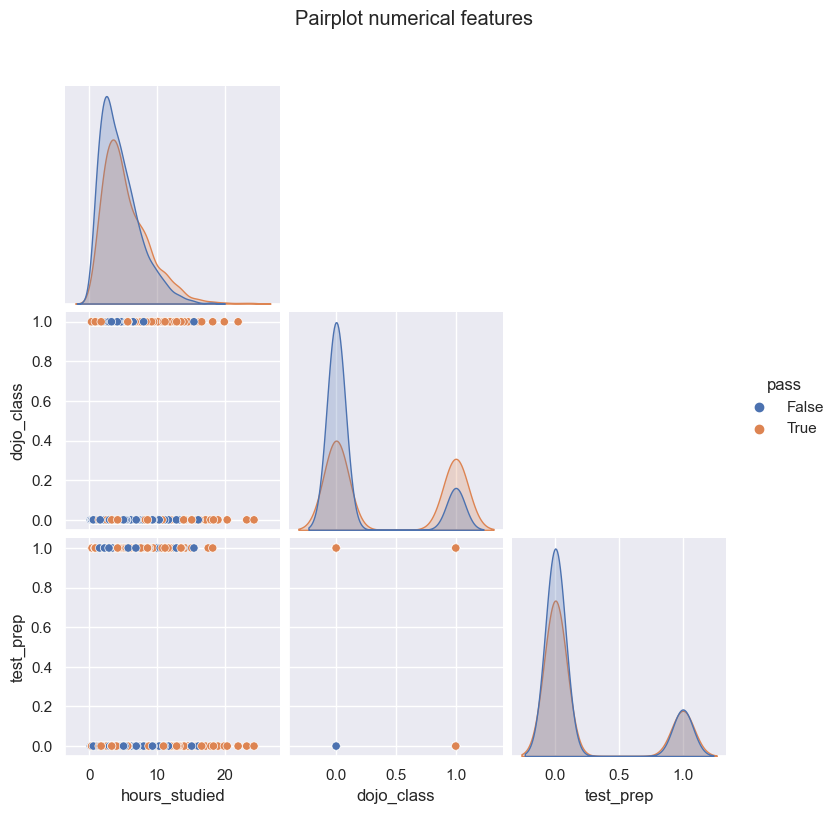

In [13]:
sns.pairplot(df[['hours_studied', 'dojo_class',
       'test_prep', 'pass']], hue='pass', corner=True)
plt.suptitle("Pairplot numerical features", y=1.08)
plt.show()


From this firts visulaization we can see that, the ones who didn't take the dojo_class are the ones who most failed. But there is a large amount of students who didn't took the prep class and still passed. Therefore it looks like dojo_class has a big relevance.

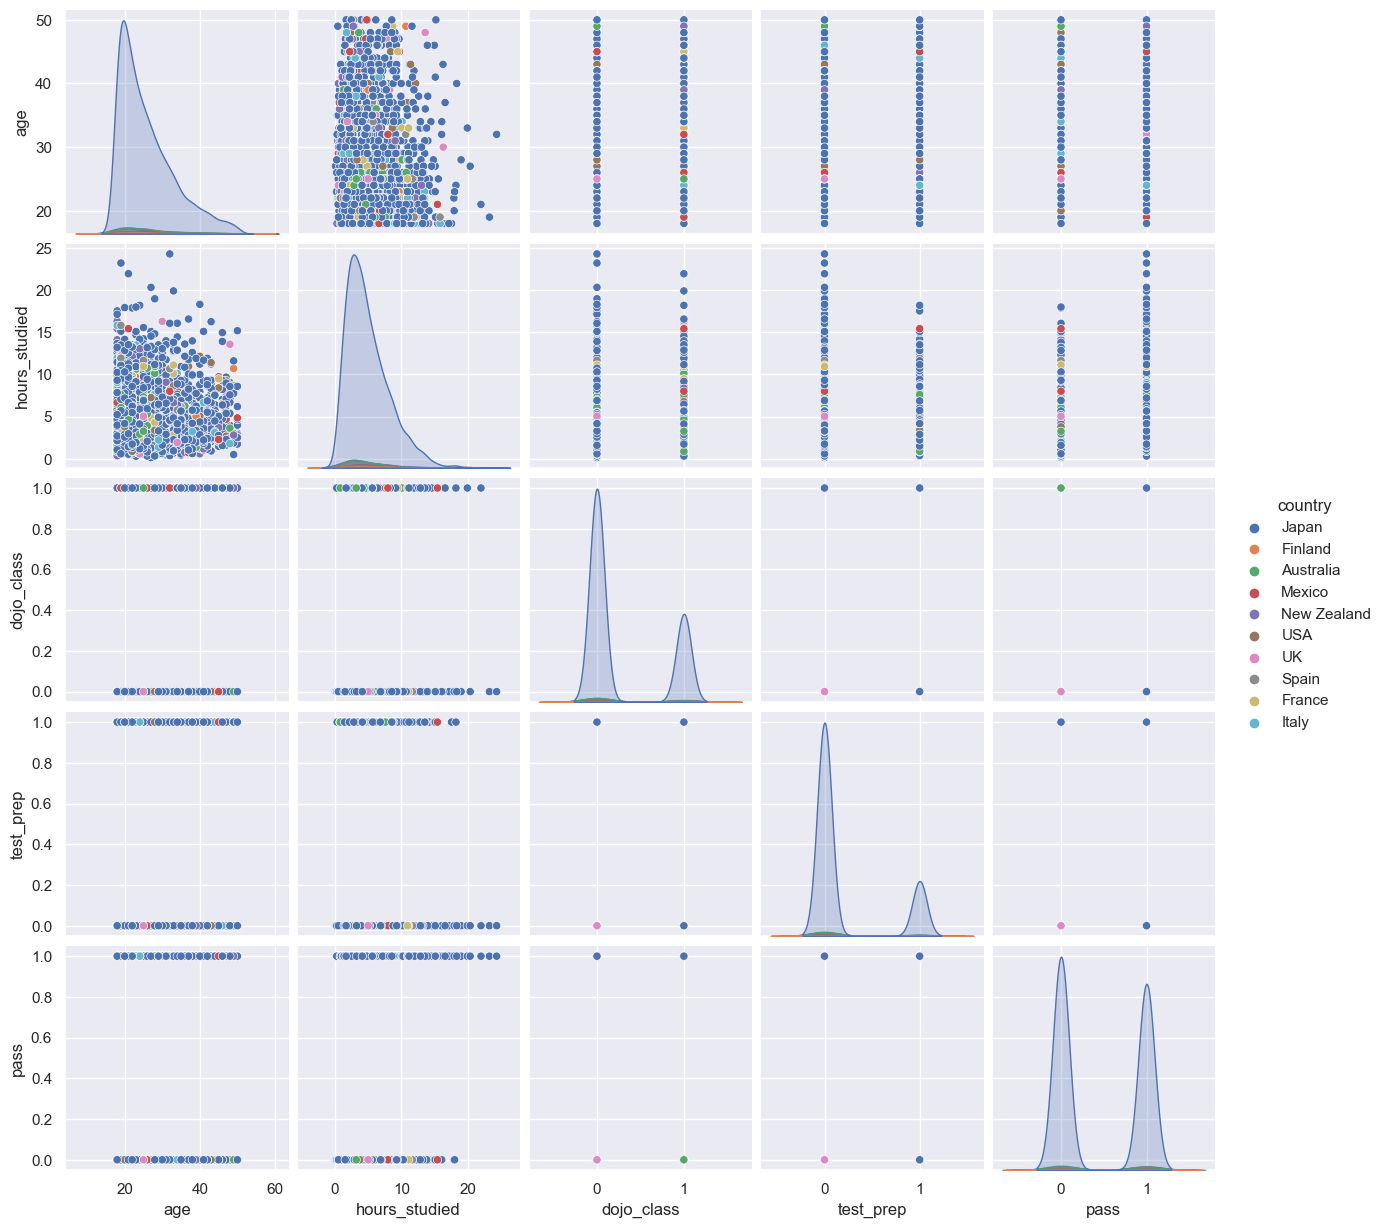

In [14]:
sns.pairplot(df, hue='country')

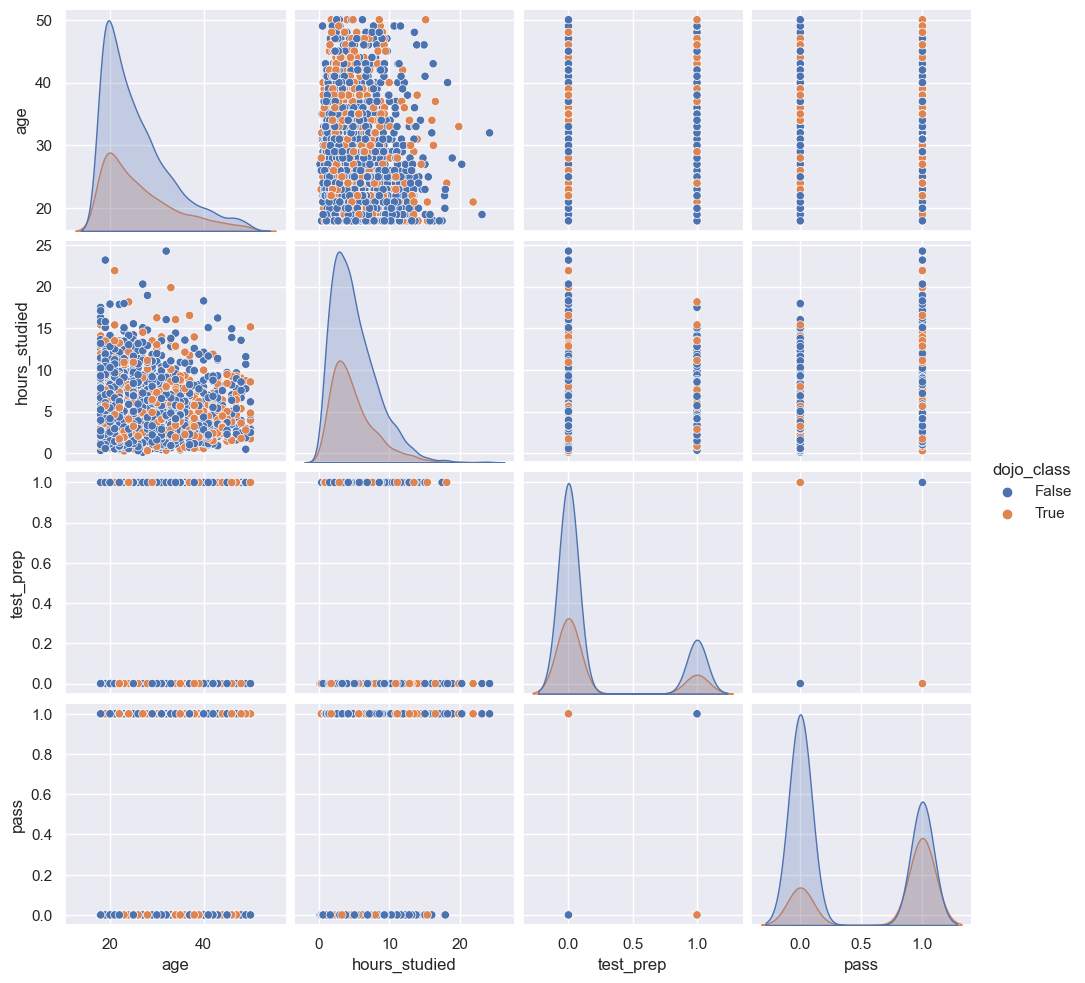

In [15]:
sns.pairplot(df, hue='dojo_class')

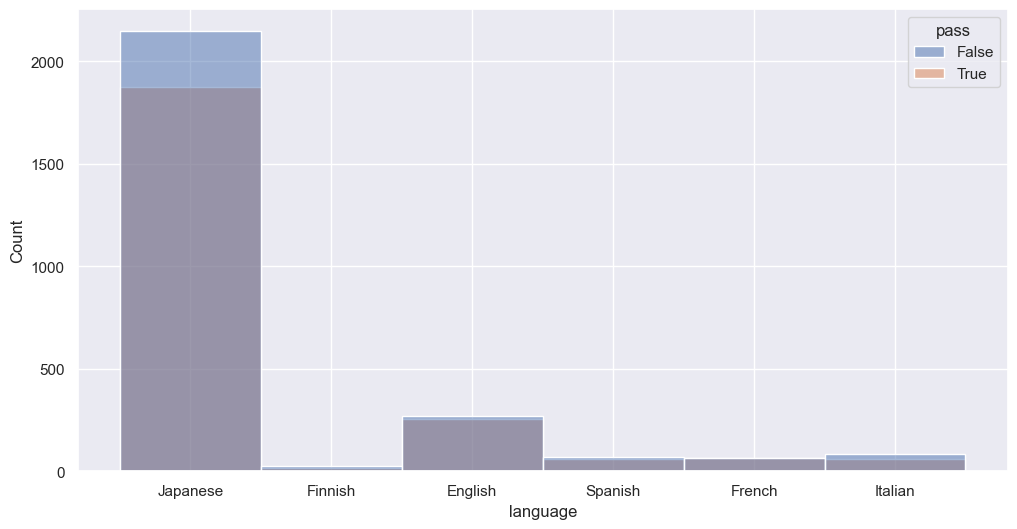

In [16]:
plt.figure(figsize=(12, 6))

sns.histplot(data=df, x="language", hue='pass')
plt.show()

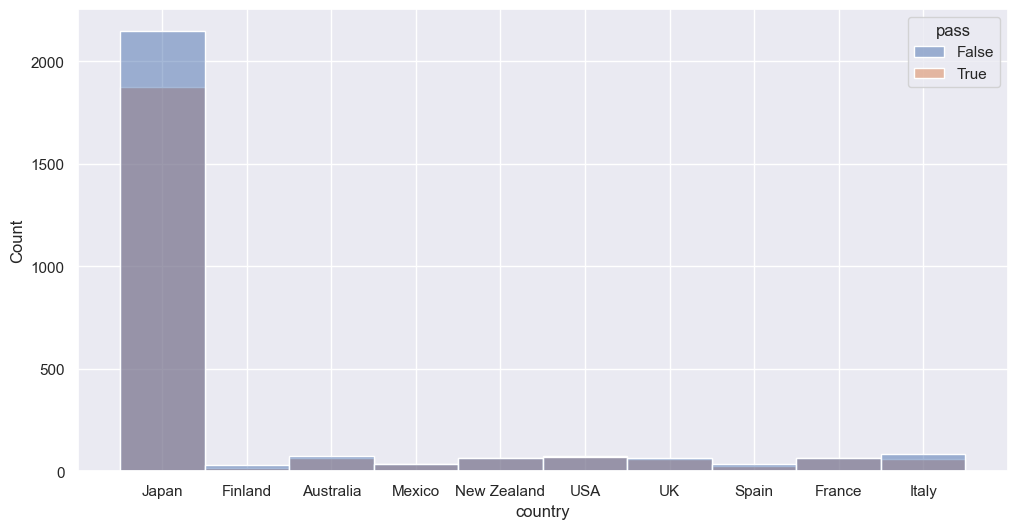

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="country", hue='pass')
plt.show()

In [18]:
df.country.value_counts(normalize=True)

country
Japan          0.8044
Italy          0.0290
USA            0.0280
Australia      0.0268
New Zealand    0.0262
France         0.0256
UK             0.0246
Mexico         0.0146
Spain          0.0118
Finland        0.0090
Name: proportion, dtype: float64

<Axes: ylabel='proportion'>

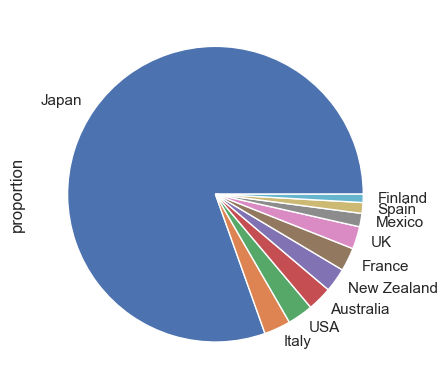

In [19]:
df.country.value_counts(normalize=True).plot.pie()

In [20]:
df.hours_studied.describe()

count    3018.000000
mean        4.964076
std         3.203037
min         0.139203
25%         2.555823
50%         4.247235
75%         6.660737
max        24.259314
Name: hours_studied, dtype: float64

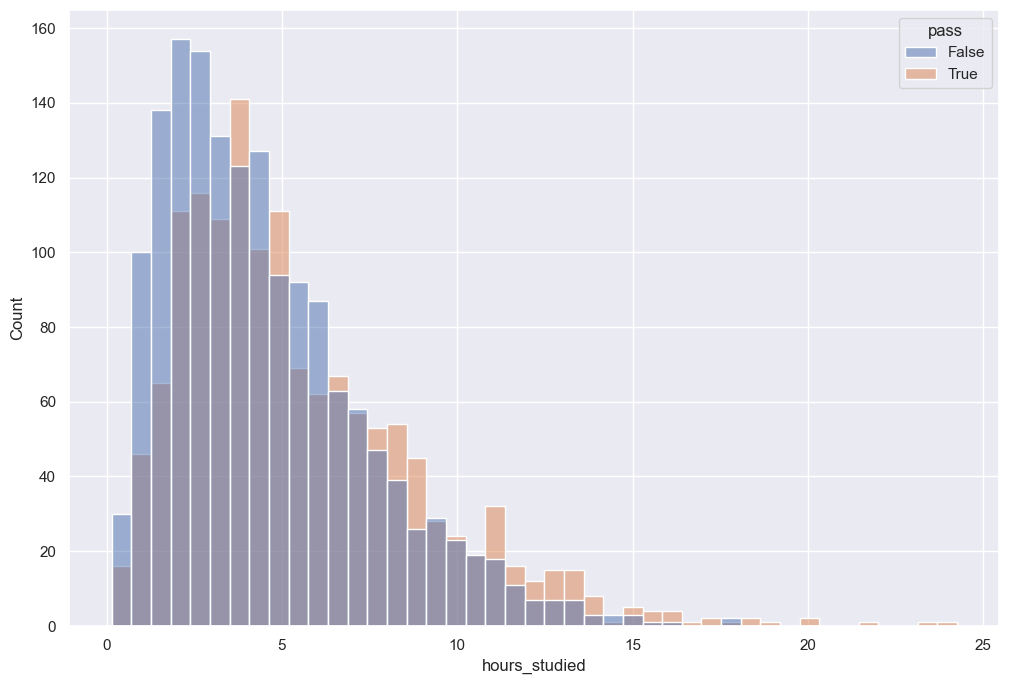

In [21]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="hours_studied", hue='pass')
plt.show()

<Axes: xlabel='sex', ylabel='Count'>

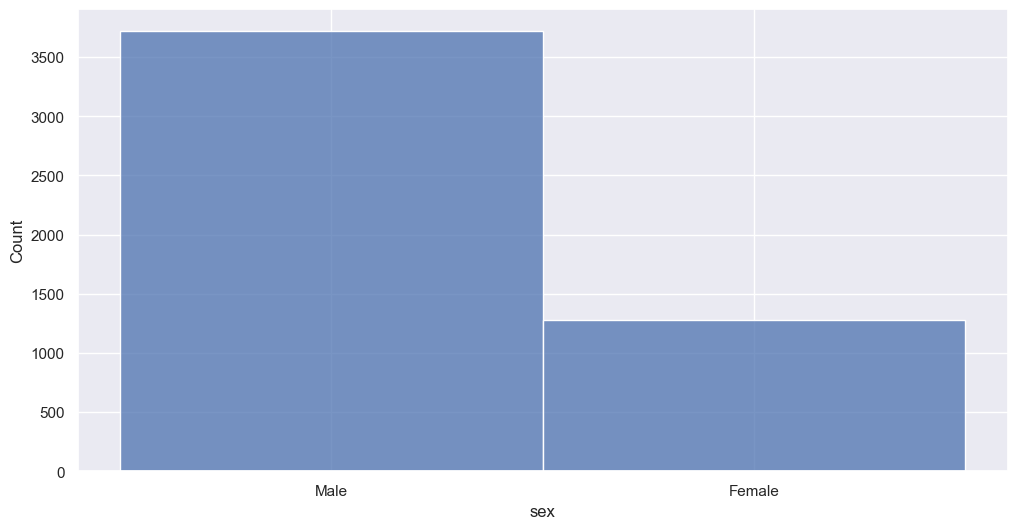

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="sex")

After this first inspection we can see: 
- most of the student on this data are from Japan, they represent the 80 %. Therefore on this regard, the data is umbalanced.
- mojo_class has a huge impact on wether a student will pass the test or not
- test_prep doesn't has tha much impact, since many of the students whon passed din't take it. Also many of the ones whon didn't passed, didn't took it.
- the mean of hours studied is around 4. But the distributionsn between passed and not passed is very balanced. Below the mean the amount of not passed is quite higher, but up the mean is very balanced.
- the gender distribution is very unbalanced (hole dataset)

### Splitting the data into target and features

In [23]:
X = df.drop('pass', axis=1) # selectiong all columns but the target
y = df['pass'] # selecting only the target
print(f"Number of observations: {X.shape[0]}")
print(f"Number of feartures: {X.shape[1]}")
print(f"The features: {list(X.columns)}")
print(f"Number of values in our target: {y.shape[0]}")

Number of observations: 5000
Number of feartures: 7
The features: ['sex', 'language', 'country', 'age', 'hours_studied', 'dojo_class', 'test_prep']
Number of values in our target: 5000


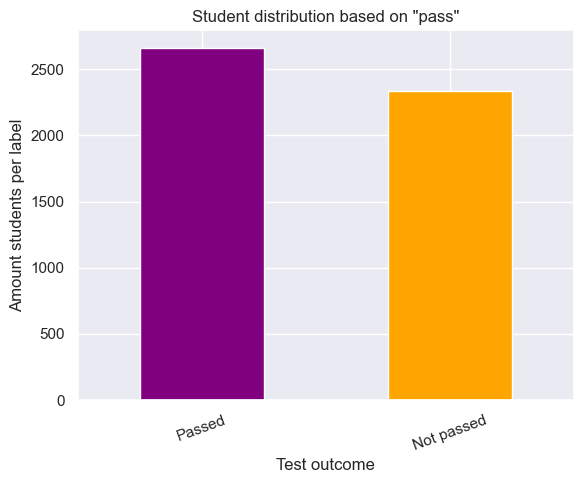

In [24]:

bar_colors = ['purple', 'orange']
y.value_counts().plot(kind='bar', color= bar_colors)
plt.xticks([0, 1], ['Passed', 'Not passed'], rotation=20)
plt.title('Student distribution based on "pass"')
plt.ylabel('Amount students per label')
plt.xlabel('Test outcome')
plt.show()

The target distribuition is very balanced

#### Creating dummies for our categorical features

In [25]:
X.columns

Index(['sex', 'language', 'country', 'age', 'hours_studied', 'dojo_class',
       'test_prep'],
      dtype='object')

In [26]:
cat_feats = ['sex', 'language', 'country'] # columns to convert

X = pd.get_dummies(X, columns = cat_feats, drop_first=True)

X.head()

,age,hours_studied,dojo_class,test_prep,sex_Male,language_Finnish,language_French,language_Italian,language_Japanese,language_Spanish,country_Finland,country_France,country_Italy,country_Japan,country_Mexico,country_New Zealand,country_Spain,country_UK,country_USA
0,20,10.578594,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
1,22,7.814520,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
2,27,4.213682,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3,24,NaN,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
4,21,3.248907,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False


In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  5000 non-null   int64  
 1   hours_studied        3018 non-null   float64
 2   dojo_class           5000 non-null   bool   
 3   test_prep            5000 non-null   bool   
 4   sex_Male             5000 non-null   bool   
 5   language_Finnish     5000 non-null   bool   
 6   language_French      5000 non-null   bool   
 7   language_Italian     5000 non-null   bool   
 8   language_Japanese    5000 non-null   bool   
 9   language_Spanish     5000 non-null   bool   
 10  country_Finland      5000 non-null   bool   
 11  country_France       5000 non-null   bool   
 12  country_Italy        5000 non-null   bool   
 13  country_Japan        5000 non-null   bool   
 14  country_Mexico       5000 non-null   bool   
 15  country_New Zealand  5000 non-null   b

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  5000 non-null   int64  
 1   hours_studied        3018 non-null   float64
 2   dojo_class           5000 non-null   bool   
 3   test_prep            5000 non-null   bool   
 4   sex_Male             5000 non-null   bool   
 5   language_Finnish     5000 non-null   bool   
 6   language_French      5000 non-null   bool   
 7   language_Italian     5000 non-null   bool   
 8   language_Japanese    5000 non-null   bool   
 9   language_Spanish     5000 non-null   bool   
 10  country_Finland      5000 non-null   bool   
 11  country_France       5000 non-null   bool   
 12  country_Italy        5000 non-null   bool   
 13  country_Japan        5000 non-null   bool   
 14  country_Mexico       5000 non-null   bool   
 15  country_New Zealand  5000 non-null   b

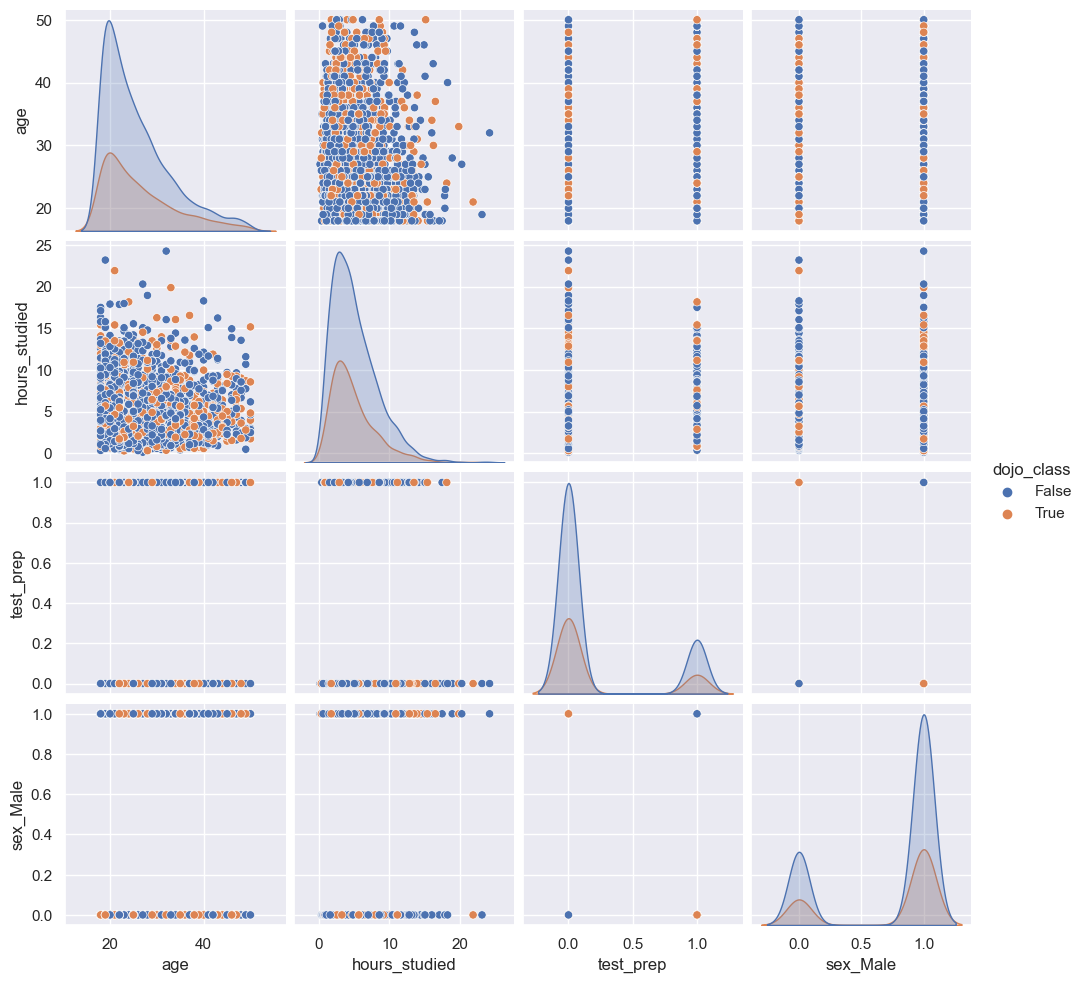

In [29]:
sns.pairplot(X[['age', 'hours_studied', 'dojo_class', 'test_prep', 'sex_Male']], hue='dojo_class')

In [30]:
X.columns

Index(['age', 'hours_studied', 'dojo_class', 'test_prep', 'sex_Male',
       'language_Finnish', 'language_French', 'language_Italian',
       'language_Japanese', 'language_Spanish', 'country_Finland',
       'country_France', 'country_Italy', 'country_Japan', 'country_Mexico',
       'country_New Zealand', 'country_Spain', 'country_UK', 'country_USA'],
      dtype='object')

<Axes: >

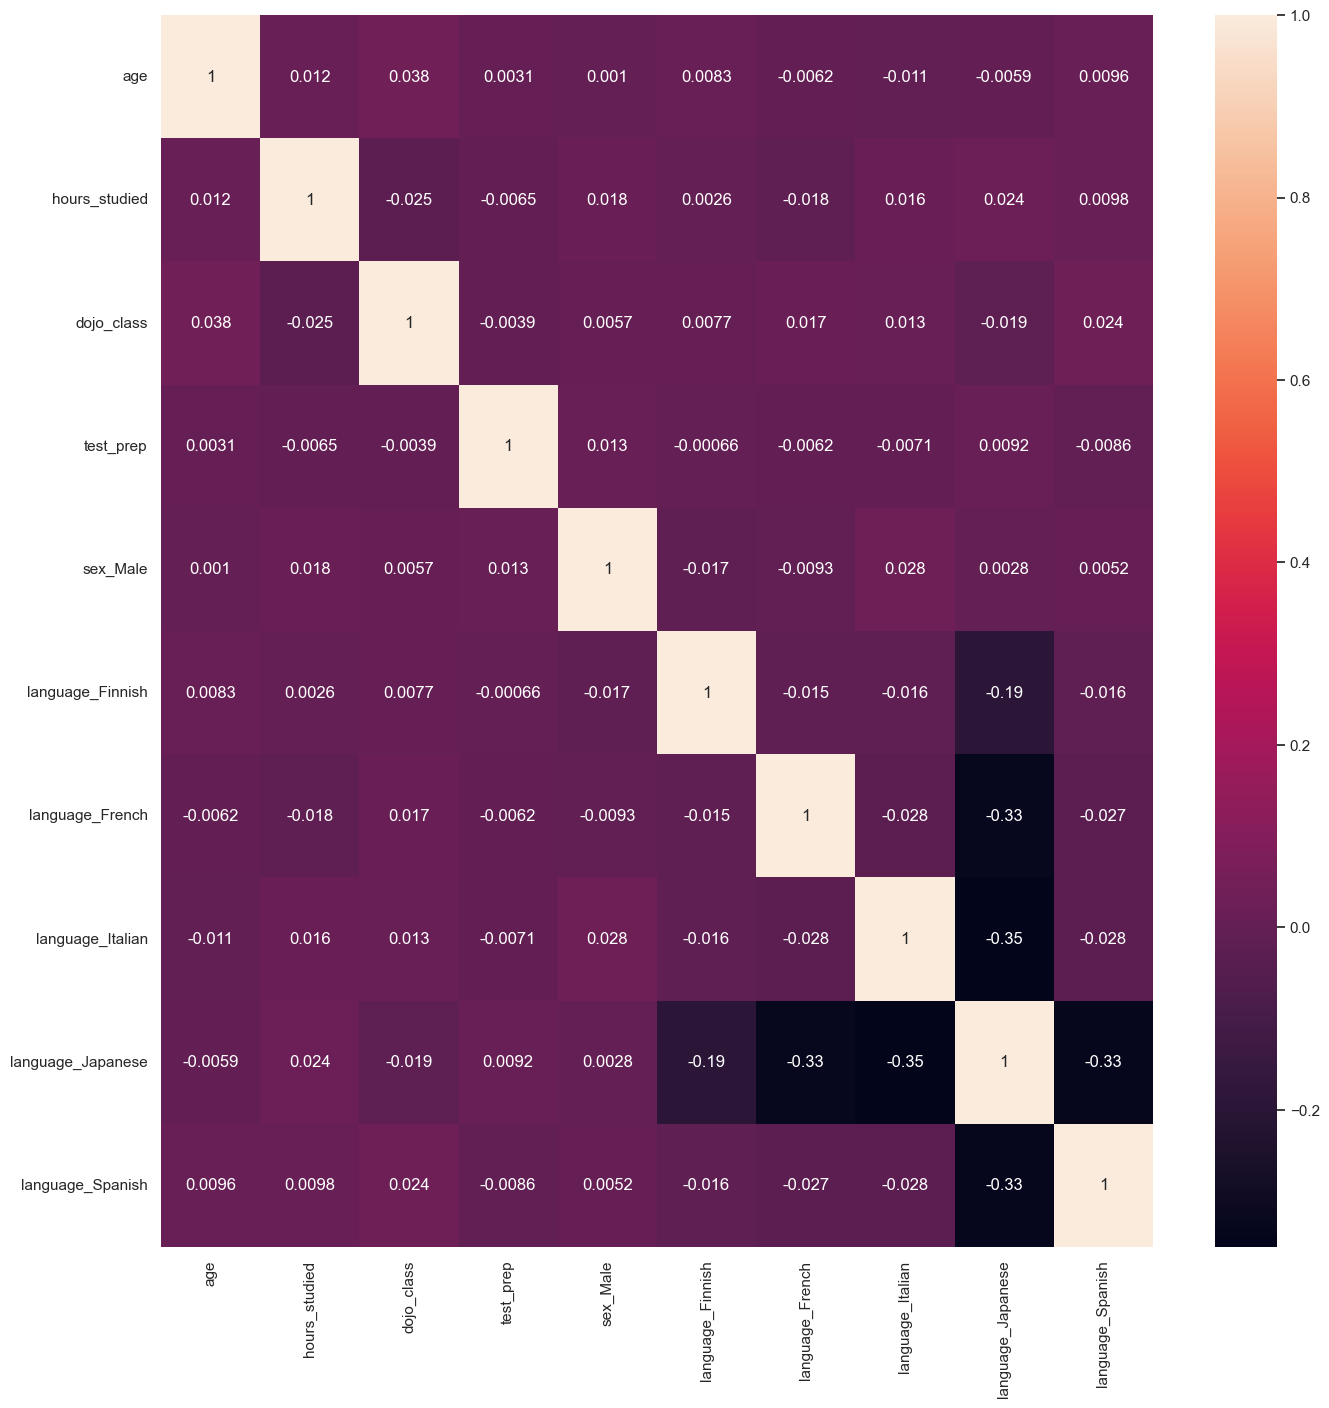

In [31]:
plt.figure(figsize=(16, 16))
sns.heatmap(X[['age', 'hours_studied', 'dojo_class', 'test_prep', 'sex_Male',
       'language_Finnish', 'language_French', 'language_Italian',
       'language_Japanese', 'language_Spanish']].corr(), annot=True)

<Axes: xlabel='pass', ylabel='Count'>

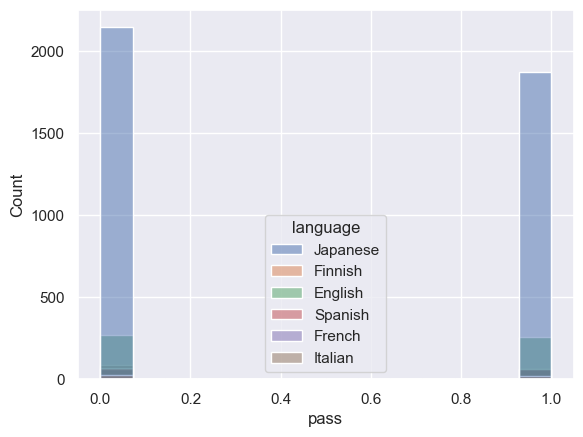

In [32]:
sns.histplot(data=df, x="pass", hue="language")

#### Spliting data into train and test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

In [34]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 19)
X_test shape: (1000, 19)
y_train shape: (4000,)
y_test shape: (1000,)


#### Dealing with missing values

In [35]:
knn_imputer = KNNImputer(missing_values=np.nan ,n_neighbors=5) # imputing nan values with values of the closest neighbours
X_train.iloc[:,1:2] = knn_imputer.fit_transform(X_train.iloc[:,1:2])
X_test.iloc[:,1:2] = knn_imputer.transform(X_test.iloc[:,1:2])

In [37]:
X_train.hours_studied = X_train.hours_studied.round().astype(int)
X_train

,age,hours_studied,dojo_class,test_prep,sex_Male,language_Finnish,language_French,language_Italian,language_Japanese,language_Spanish,country_Finland,country_France,country_Italy,country_Japan,country_Mexico,country_New Zealand,country_Spain,country_UK,country_USA
4002,45,4,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3991,18,3,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3359,27,5,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
4125,20,5,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
4147,19,5,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,33,5,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
1239,22,6,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
3052,42,3,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
1611,20,5,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False


### Logistic regression as baseline model

In [38]:
log_r = LogisticRegression(random_state=RSEED)
log_r.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [39]:
# Predicting on train data 
y_train_pred = log_r.predict(X_train)
y_train_prob = log_r.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
y_pred = log_r.predict(X_test)
y_prob = log_r.predict_proba(X_test)[:, 1]

### Results on Training data

Accuracy : 0.66
Recall : 0.65
Precision: 0.67
ROC: 0.74
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.65      0.77      0.71      2132
        True       0.67      0.53      0.59      1868

    accuracy                           0.66      4000
   macro avg       0.66      0.65      0.65      4000
weighted avg       0.66      0.66      0.65      4000



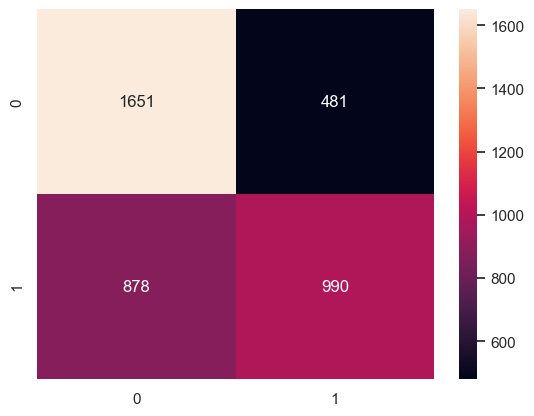

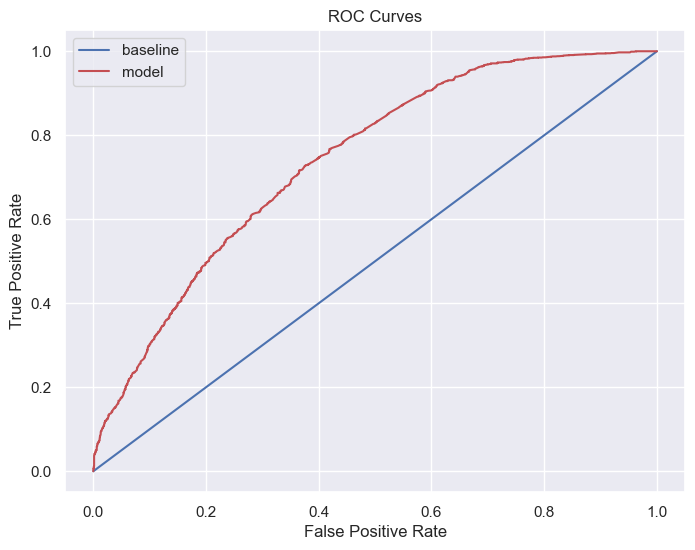

In [40]:
base_fpr, base_tpr, _ = roc_curve(y_train, [1 for _ in range(len(y_train))])
model_fpr, model_tpr, _ = roc_curve(y_train, y_train_prob)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_train, y_train_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, y_train_pred, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred)))
print("ROC: {:.2f}".format(roc_auc_score(y_train, y_train_prob)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, y_train_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();


### Results on Test data

Accuracy : 0.64
Recall : 0.64
Precision: 0.65
ROC: 0.70
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.64      0.77      0.70       533
        True       0.65      0.50      0.57       467

    accuracy                           0.64      1000
   macro avg       0.65      0.64      0.63      1000
weighted avg       0.65      0.64      0.64      1000



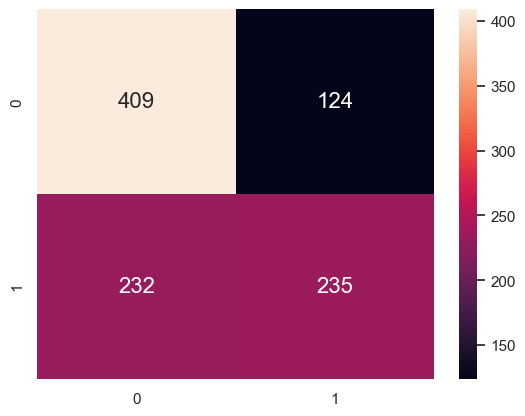

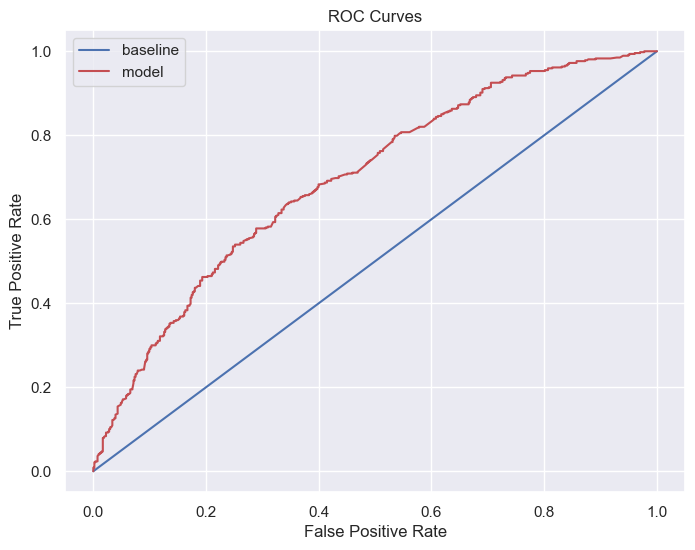

In [41]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_prob)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("ROC: {:.2f}".format(roc_auc_score(y_test, y_prob)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, y_pred)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();


As espected, the results are better on training set that on test set, but the differences aren't that huge

### Training a random forest model

In [42]:

rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='gini',
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, 
                               verbose = 1,
                               bootstrap=False)
rf_model.fit(X_train, y_train)


n_nodes = []
max_depths = []

for ind_tree in rf_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

Average number of nodes 2120
Average maximum depth 25


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_

### Results on Training set

Accuracy : 0.81
Recall : 0.81
Precision: 0.88
ROC: 0.92
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.78      0.92      0.84      2132
        True       0.88      0.70      0.78      1868

    accuracy                           0.81      4000
   macro avg       0.83      0.81      0.81      4000
weighted avg       0.82      0.81      0.81      4000



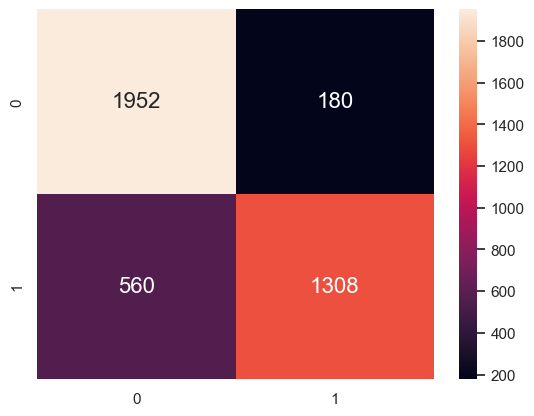

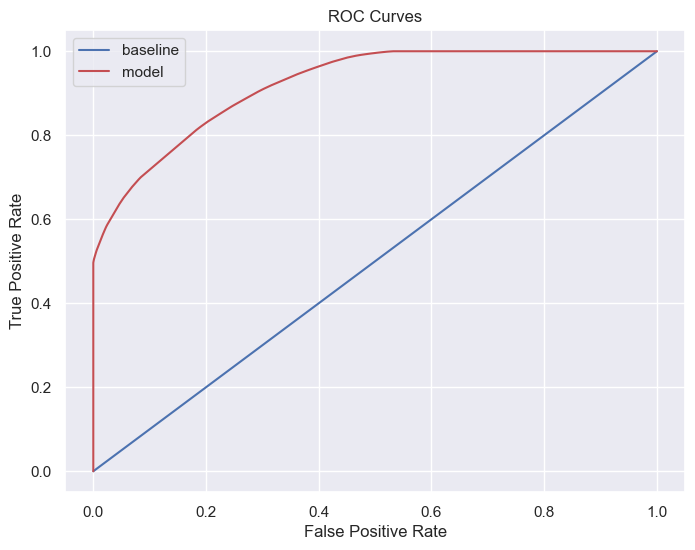

In [43]:
base_fpr, base_tpr, _ = roc_curve(y_train, [1 for _ in range(len(y_train))])
model_fpr, model_tpr, _ = roc_curve(y_train, train_rf_probs)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_rf_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, train_rf_predictions)))
print("ROC: {:.2f}".format(roc_auc_score(y_train, train_rf_probs)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_rf_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();


### Results ion test set

Accuracy : 0.63
Recall : 0.63
Precision: 0.63
ROC: 0.68
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.64      0.73      0.68       533
        True       0.63      0.52      0.57       467

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



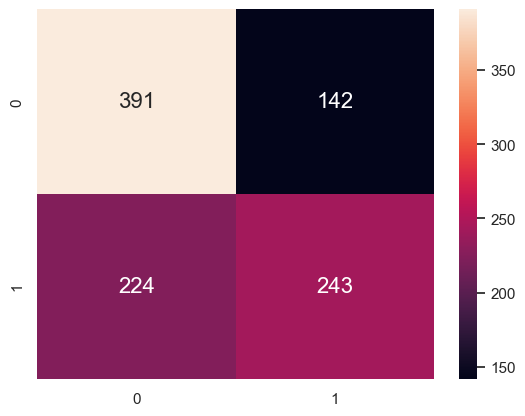

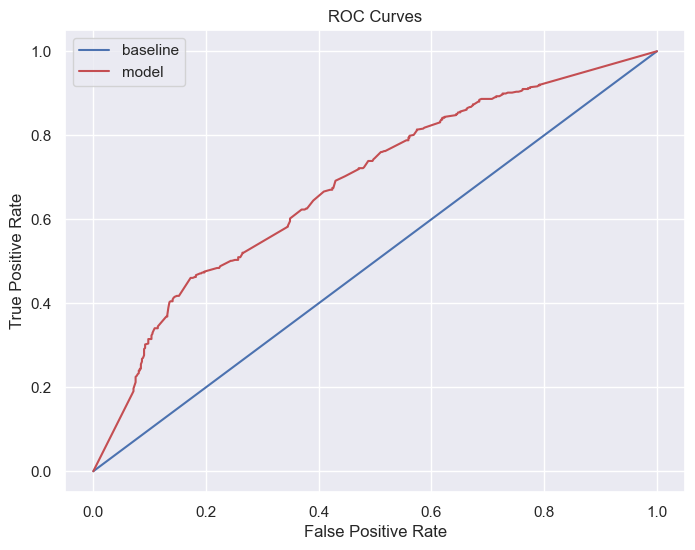

In [44]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, rf_probs)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, rf_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, rf_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, rf_predictions)))
print("ROC: {:.2f}".format(roc_auc_score(y_test, rf_probs)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, rf_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

It seems that the model was overfitting the data, since the diference in the results are notizable

### Training a XGBoostClassifier with pipeline

In [45]:
pipe_xgb = Pipeline([
    ('xgb', XGBClassifier())
])

setting parameters

In [46]:
param_xgb = {'xgb__base_score':[0.5],
                'xgb__booster': ['gbtree'],
                'xgb__learning_rate': [0.01, 0.001],
                'xgb__max_depth': [4, 6, 10],
                'xgb__random_state': [RSEED],
                'xgb__n_estimators': [100],
                'xgb__colsample_bytree': [0.5]
               }

grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb, cv=5, scoring= 'accuracy', 
                           verbose=5, n_jobs=-1)

In [47]:
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV 2/5] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=100, xgb__random_state=42;, score=0.676 total time=   0.3s
[CV 1/5] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=100, xgb__random_state=42;, score=0.684 total time=   0.2s
[CV 3/5] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=100, xgb__random_state=42;, score=0.686 total time=   0.2s
[CV 4/5] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=100, xgb__random_state=42;, score=0.699 total time=   0.2s
[CV 5/5] END xgb__base_score=0.5, xgb__booster=gbtree, xgb__colsample_bytree=0.5, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=100, xgb__random_state=42;, score=0.655 total tim

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__base_score': [0.5], 'xgb__booster': ['gbtree'],
                         'xgb__colsample_bytree': [0.5],
                         'xgb__learning_rate': [0.01, 0.001],
                         'xgb__max_depth': [4, 6, 10],
                         'xgb__n_estimators': [100],
                         'xgb__random_state': [42]},
             scoring='accuracy', verbose=5)

In [48]:
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))

Best score:
0.68
Best parameters:
{'xgb__base_score': 0.5, 'xgb__booster': 'gbtree', 'xgb__colsample_bytree': 0.5, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 4, 'xgb__n_estimators': 100, 'xgb__random_state': 42}


In [49]:
best_model_dt = grid_xgb.best_estimator_
best_model_dt

Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [50]:
# Training predictions (to demonstrate overfitting)
train_xgb_predictions = best_model_dt.predict(X_train)
train_xgb_probs = best_model_dt.predict_proba(X_train)[:, 1]

# Testing predictions (to determine performance)
xgb_predictions = best_model_dt.predict(X_test)
xgb_probs = best_model_dt.predict_proba(X_test)[:, 1]

### Predictions on training

Accuracy : 0.69
Recall : 0.68
Precision: 0.72
ROC: 0.77
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.68      0.82      0.74      2132
        True       0.72      0.55      0.63      1868

    accuracy                           0.69      4000
   macro avg       0.70      0.68      0.68      4000
weighted avg       0.70      0.69      0.69      4000



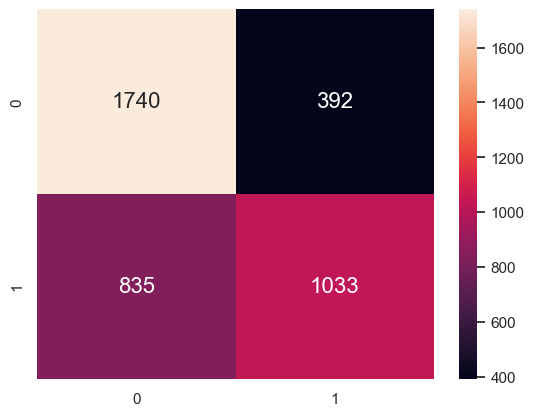

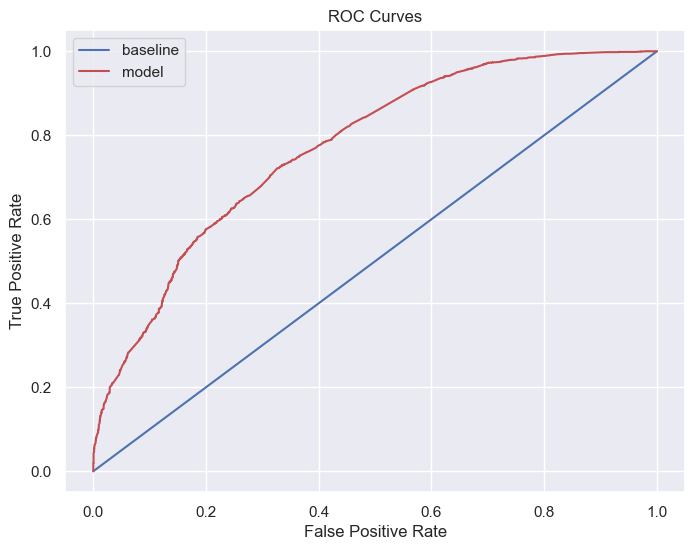

In [51]:
base_fpr, base_tpr, _ = roc_curve(y_train, [1 for _ in range(len(y_train))])
model_fpr, model_tpr, _ = roc_curve(y_train, train_xgb_probs)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_train, train_xgb_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_train, train_xgb_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, train_xgb_predictions)))
print("ROC: {:.2f}".format(roc_auc_score(y_train, train_xgb_probs)))
print('------'*10)
print(f'Classification Report: {classification_report(y_train, train_xgb_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_train, train_xgb_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();

### Predictions on test

Accuracy : 0.68
Recall : 0.67
Precision: 0.71
ROC: 0.71
------------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

       False       0.66      0.82      0.73       533
        True       0.71      0.51      0.60       467

    accuracy                           0.68      1000
   macro avg       0.68      0.67      0.66      1000
weighted avg       0.68      0.68      0.67      1000



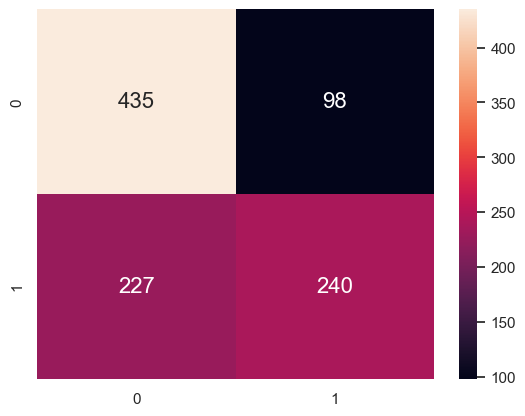

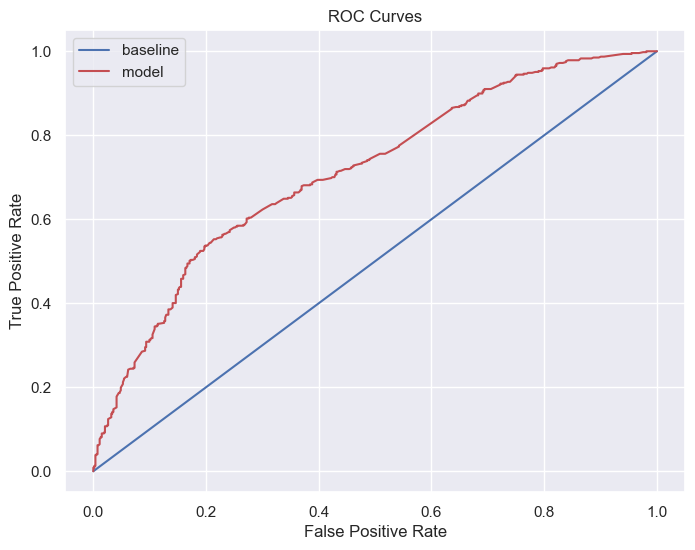

In [52]:
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, xgb_probs)

# Printing results
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, xgb_predictions, normalize=True)))
print('Recall : {:.2f}'.format(recall_score(y_test, xgb_predictions, average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, xgb_predictions)))
print("ROC: {:.2f}".format(roc_auc_score(y_test, xgb_probs)))
print('------'*10)
print(f'Classification Report: {classification_report(y_test, xgb_predictions)}') 

# Plotting the confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt = 'd')

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16


# Plotting the ROC curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); 
plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
plt.show();